# Density Evolution of Regular LDPC Codes for the BI-AWGN Channel

This code is provided as supplementary material of the lecture Channel Coding - Graph-based Codes.

This code illustrates
* Using particle filtering methods to get estimates of the probability density functions of the messages passed during message passing decoding 
* Visualization of the message pdfs

In [42]:
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from ipywidgets import interactive
import ipywidgets as widgets
rng = np.random.default_rng()

Helper functions

In [78]:
def sign_corr(x):
    s = np.sign(x)
    s[x==0] = (-1)**rng.integers(2, size=s[x==0].shape)
    return s

def phi(x):
    x = np.asarray(x)
    x = np.maximum(x, 1e-30)   # clip safely
    return -np.log(np.tanh(x / 2))

In [74]:
# density evolution of a simple regular LDPC code with the particle method
# (population dynamics)
def PDF_Evolution_MonteCarlo_BiAWGN(dv, dc, EbN0_dB, iterations):
    #dv = 3
    #dc = 6
    #EbN0_dB = 2.1

    # design rate
    rd = 1 - dv/dc

    EsN0_db = EbN0_dB + 10 * np.log10(rd)

    # noise standard deviation
    sigma_n = np.sqrt(0.5 * 10**(-EsN0_db / 10))

    # number of decoding iterations
    #iterations = 11

    # slows down quite a lot! Use with care and only for debugging
    display_histogram = True

    # population size
    N = 1000000

    # all-zero codeword (+1) with errors
    z = 1 + sigma_n * rng.standard_normal(size=N)

    LLRs = z * 2 / (sigma_n**2)

    CN_messages = np.zeros(shape=N)
    VNh = []
    VXh = []
    CNh = []
    CXh = []

    for i in tqdm(range(iterations)):
        # compute VN to CN messages
        if i == 0:
            VN_messages = LLRs
        else:
            # VN operation
            VN_messages = LLRs[rng.integers(N, size=N)] + np.sum(CN_messages[rng.integers(N, size=(N, dv-1))], axis=1)
        
        if display_histogram:
            # histograms for display/debug purposes
            bins = np.arange(-10, 30.5, 0.5)
            H, edges = np.histogram(VN_messages, bins=bins, density=True)
            VNh.append(H) # store count of bins
            VXh.append(0.5 * (edges[:-1] + edges[1:])) # calculate bin centers

        if (not display_histogram) and (np.all(VN_messages > 0)):
            # no more errors, abort
            print(f"No errors after {i} iterations")
            break

        CN_messages = np.zeros(shape=N)
        # here, implement the sum product rule
        idx = rng.integers(N, size=(N, dc-1))
        CN_messages = phi(np.sum(phi(np.abs(VN_messages[idx])), axis=1)) * np.prod(sign_corr(VN_messages[idx]), axis=1)

        if display_histogram:
            bins = np.arange(-10, 30.5, 0.1)
            H, edges = np.histogram(CN_messages, bins=bins, density=True)
            CNh.append(H) # store count of bins
            CXh.append(0.5 * (edges[:-1] + edges[1:])) # calculate bin centers
        
        if np.all(VN_messages > 0):
            # no more errors, abort
            print(f"No errors")
            break
    
    if display_histogram:
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        for k in range(i):
            plt.plot(VXh[k], VNh[k])
        plt.title("VN to CN messages")
        plt.margins(x=0)
        plt.xlabel('$L$')
        plt.ylabel(r'$f_{L_{v \to c}}(L)$')
        #plt.grid()

        plt.subplot(1,2,2)
        for k in range(i):
            plt.plot(CXh[k], CNh[k])
        plt.title("CN to VN messages")
        plt.margins(x=0)
        plt.xlabel('$L$')
        plt.ylabel(r'$f_{L_{c \to v}}(L)$')
        #plt.grid()

        plt.show()

  0%|          | 0/11 [00:00<?, ?it/s]

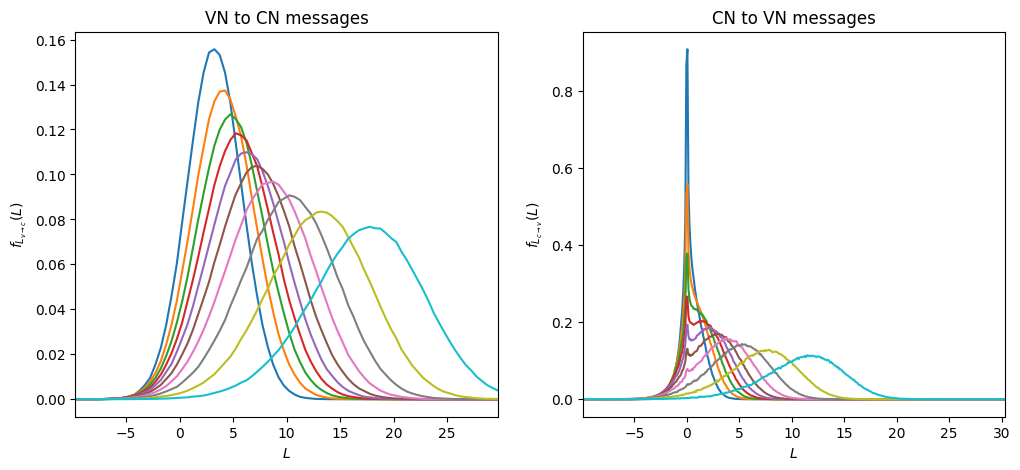

In [75]:
PDF_Evolution_MonteCarlo_BiAWGN(3, 6, 2.1, 11)

Interactive module, plot pdf for a specific iteration at a specific value of $E_b/N_0$

In [76]:
def PDF_Evolution_MonteCarlo_BiAWGN_singleiteration(dv, dc, EbN0_dB, iteration):
    # design rate
    rd = 1 - dv/dc

    EsN0_db = EbN0_dB + 10 * np.log10(rd)

    # noise standard deviation
    sigma_n = np.sqrt(0.5 * 10**(-EsN0_db / 10))

    # population size
    N = 1000000

    # all-zero codeword (+1) with errors
    z = 1 + sigma_n * rng.standard_normal(size=N)

    LLRs = z * 2 / (sigma_n**2)

    CN_messages = np.zeros(shape=N)
    VNh = []
    VXh = []
    CNh = []
    CXh = []

    for i in range(iteration):
        # compute VN to CN messages
        if i == 0:
            VN_messages = LLRs
        else:
            # VN operation
            VN_messages = LLRs[rng.integers(N, size=N)] + np.sum(CN_messages[rng.integers(N, size=(N, dv-1))], axis=1)
        
        if i == iteration-1:
            # histograms for display/debug purposes
            bins = np.arange(-10, 30.5, 0.5)
            H, edges = np.histogram(VN_messages, bins=bins, density=True)
            VNh.append(H) # store count of bins
            VXh.append(0.5 * (edges[:-1] + edges[1:])) # calculate bin centers

        CN_messages = np.zeros(shape=N)
        # here, implement the sum product rule
        idx = rng.integers(N, size=(N, dc-1))
        CN_messages = phi(np.sum(phi(np.abs(VN_messages[idx])), axis=1)) * np.prod(sign_corr(VN_messages[idx]), axis=1)

        if i == iteration-1:
            bins = np.arange(-10, 30.5, 0.1)
            H, edges = np.histogram(CN_messages, bins=bins, density=True)
            CNh.append(H) # store count of bins
            CXh.append(0.5 * (edges[:-1] + edges[1:])) # calculate bin centers
        
    
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(VXh[0], VNh[0])
    plt.title("VN to CN messages (iter. {})".format(iteration))
    plt.xlim(-10, 30)
    plt.margins(x=0)
    plt.xlabel('$L$')
    plt.ylabel(r'$f_{L_{v \to c}}(L)$')    
    #plt.grid()

    plt.subplot(1,2,2)
    plt.plot(CXh[0], CNh[0])
    plt.title("CN to VN messages (iter. {})".format(iteration))
    plt.margins(x=0)
    plt.xlim(-10, 30)
    plt.xlabel('$L$')
    plt.ylabel(r'$f_{L_{c \to v}}(L)$')
    #plt.grid()

    plt.show()

In [ ]:
interactive_plot = interactive(PDF_Evolution_MonteCarlo_BiAWGN_singleiteration, \
                               dv = widgets.IntSlider(min=2, max=6, step=1, value=3, continuous_update=False, description=r'\(d_{\mathtt{v}}\)'), \
                               dc = widgets.IntSlider(min=2, max=15, step=1, value=6, continuous_update=False, description=r'\(d_{\mathtt{c}}\)'), \
                               EbN0_dB = widgets.FloatSlider(min=-1.58, max=5, step=0.1, value=2.1, continuous_update=False, description=r'\(E_{\mathrm{b}}/N_0\) (dB)'), \
                               iteration = widgets.IntSlider(min=2, max=15, step=1, value=5, continuous_update=False, description='Iteration'))
output = interactive_plot.children[-1]
output.layout.height = '500px'
interactive_plot

interactive(children=(IntSlider(value=3, continuous_update=False, description='\\(d_{\\mathtt{v}}\\)', max=6, …